# 6.6. Concise Implementation of LeNet5

이번 실습은 ch4에서 다루었던 fashion-mnist dataset을 통한 MLP예제를 LeNet5로 바꾸어 봅니다.
- Convolutional layer를 포함하는 것을 제외하면 기본적인 구조는 기존의 예제와 거의 비슷합니다.
- 이번 실습부터는 GPU를 활용하기 위한 코드가 추가됩니다. PyTorch에서 GPU를 활용하는 방법을 익히도록 합니다.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

colab을 사용하는 경우에는 google drive를 mount하도록 합니다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
root = '/content/drive/My Drive/hufs'

In [4]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


## Getting the Dataset



In [0]:
pil2tensor = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root, train=True, transform=pil2tensor, target_transform=None, download=True)
mnist_valid = torchvision.datasets.FashionMNIST(root, train=False, transform=pil2tensor, target_transform=None, download=True)
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [8]:
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /content/drive/My Drive/hufs
    Split: Train
    StandardTransform
Transform: ToTensor()

## The Model, Loss, Data_loader and parameters


In [0]:
# setting hyper-parameters
batch_size = 100
learning_rate = 0.9
num_epochs = 15
num_workers = 0

# defining data_iter, linreg. model, loss, sgd
train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
valid_iter = DataLoader(mnist_valid, batch_size, shuffle=False, num_workers=num_workers)

아래와 같이 LeNet5를 정의합니다.

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
net = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.Linear(in_features=16*5*5, out_features=120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

xavier initialization을 사용하여 convolutional layer들과 fully connected layer들의 파라미터들을 초기화하고, GPU를 사용할 수 있도록 .to(device)를 실행합니다.

In [11]:
torch.nn.init.xavier_uniform_(net[0].weight)
torch.nn.init.xavier_uniform_(net[3].weight)
torch.nn.init.xavier_uniform_(net[7].weight)
torch.nn.init.xavier_uniform_(net[9].weight)
torch.nn.init.xavier_uniform_(net[11].weight)
net = net.to(device)
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten()
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

model을 device에 할당시켰기 때문에 input, output도 device에 할당을 시켜야 합니다. 마찬가지로 .to(device)입니다.

In [12]:
X = torch.randn(size=(1,1,28,28), dtype = torch.float32)
X = X.to(device)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


loss와 algorithm은 MLP실습에서와 동일하게 하겠습니다.

In [13]:
# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd



Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten()
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

## Model Training
model을 훈련하면서 train loss, train accuracy, valid accuracy를 관찰합니다.
hyperparameter들을 바꿔가면서 결과를 비교해 봅니다.

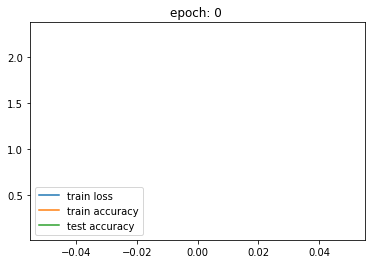

train loss:  2.265888671875
train accuracy:  0.12266666442155838
valid accuracy:  0.45809999108314514


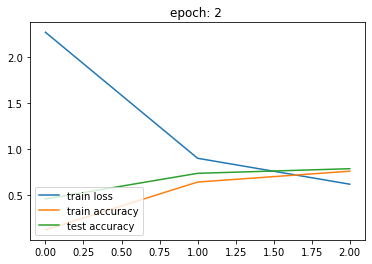

train loss:  0.6183387756347656
train accuracy:  0.7592833042144775
valid accuracy:  0.786300003528595


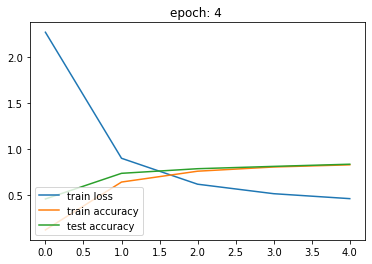

train loss:  0.46171859741210936
train accuracy:  0.8284500241279602
valid accuracy:  0.835099995136261


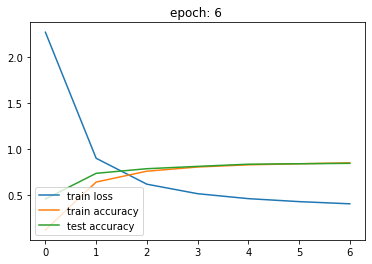

train loss:  0.4057745361328125
train accuracy:  0.8502333164215088
valid accuracy:  0.8446000218391418


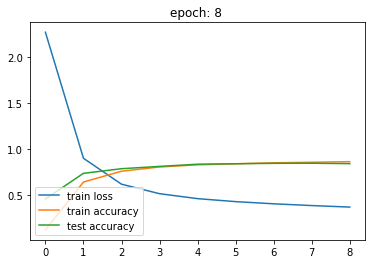

train loss:  0.37025174458821614
train accuracy:  0.8627499938011169
valid accuracy:  0.8411999940872192


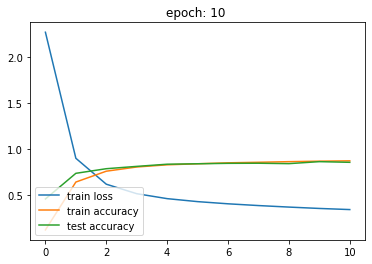

train loss:  0.343274180094401
train accuracy:  0.871749997138977
valid accuracy:  0.8555999994277954


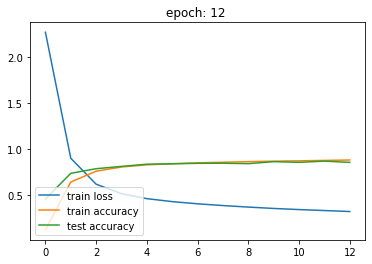

train loss:  0.3220558166503906
train accuracy:  0.8806333541870117
valid accuracy:  0.8550000190734863


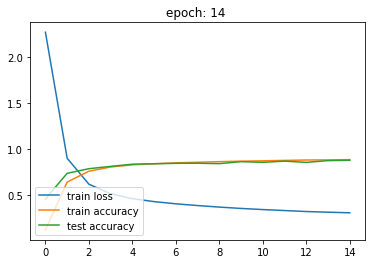

train loss:  0.3082622528076172
train accuracy:  0.8847000002861023
valid accuracy:  0.8779000043869019


In [14]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device)
    y_hat=net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()  

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,correct.cpu()/60000.)

  correct = 0
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat = net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
  accs_valid = np.append(accs_valid,correct.cpu()/10000.)


  if epoch%2 == 0:
    plt.plot(loss_train,label='train loss')
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='test accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)

    print('train loss: ',loss_train[-1])
    print('train accuracy: ',accs_train[-1])
    print('valid accuracy: ',accs_valid[-1])  

## Prediction

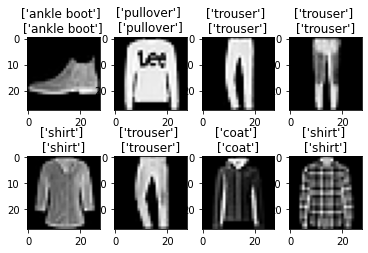

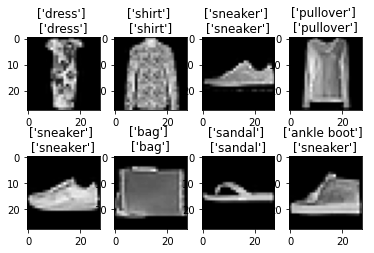

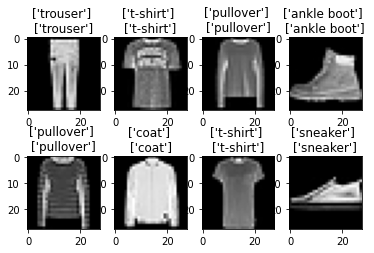

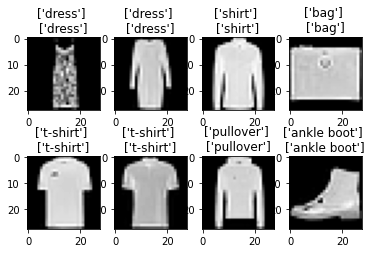

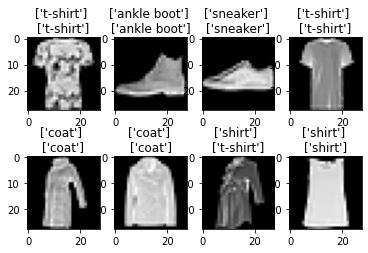

In [15]:
i = 0
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = net(X)    
  y_hat = y_hat.argmax(dim=1)
  for n in range(8):
    plt.subplot(241+n)
    plt.imshow(X[n].cpu().squeeze(),cmap='gray')
    plt.title('%s \n%s'%(get_fashion_mnist_labels([y[n]]),get_fashion_mnist_labels([y_hat[n]])))
  plt.pause(.0001)
  if i>4:
     break

## Softmax


torch.Size([1, 28, 28])
y1 = 
 tensor([[-3.7084, -4.8744, -4.3955, -4.4032, -1.6798,  3.7340, -3.1399,  6.2802,
         -0.3266, 11.7188]], device='cuda:0', grad_fn=<AddmmBackward>)


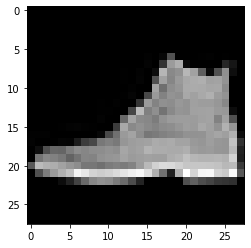

In [16]:
X1 = X[1]
print(X1.shape)
y1 = net(X1.reshape(-1,1,28,28))
print('y1 = \n',y1)
plt.imshow(X1.cpu().squeeze(),cmap='gray')

fully connected layer의 output은 probability의 형태가 아닙니다. 우리는 softmax를 통해 output을 probability의 형태로 출력할 수 있습니다.

In [17]:
y1_softmax = y1.softmax(dim=1)
print('y1_softmax = \n',y1_softmax)

print('\nsum of y1_softmax = \n',torch.sum(y1_softmax))

print('\n 100 x y1_softmax = \n',(100*y1_softmax).long())


y1_softmax = 
 tensor([[1.9863e-07, 6.1892e-08, 9.9913e-08, 9.9143e-08, 1.5102e-06, 3.3900e-04,
         3.5069e-07, 4.3253e-03, 5.8439e-06, 9.9533e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

sum of y1_softmax = 
 tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

 100 x y1_softmax = 
 tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0, 99]], device='cuda:0')


우리는 예측결과를 다음과 같이 확률과 함께 출력해 줄 수 있습니다.

In [18]:
print('predicted: %s with probability %f'%(get_fashion_mnist_labels([y1_softmax.argmax(dim=1)]), y1_softmax.max()))

predicted: ['ankle boot'] with probability 0.995328
